# Synthetic data test: Proof of concept

The main goal of this synthetic is to show that the method works under ideal circumstances. It will show how the solution converges. This is also the first synthetic that will be shown in the paper.

In [1]:
import numpy as np
import harmonica as hm
import verde as vd
import matplotlib.pyplot as plt
import euler

## Create a model and data

Number of data: 8181


/home/leo/miniforge3/envs/euler-inversion/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


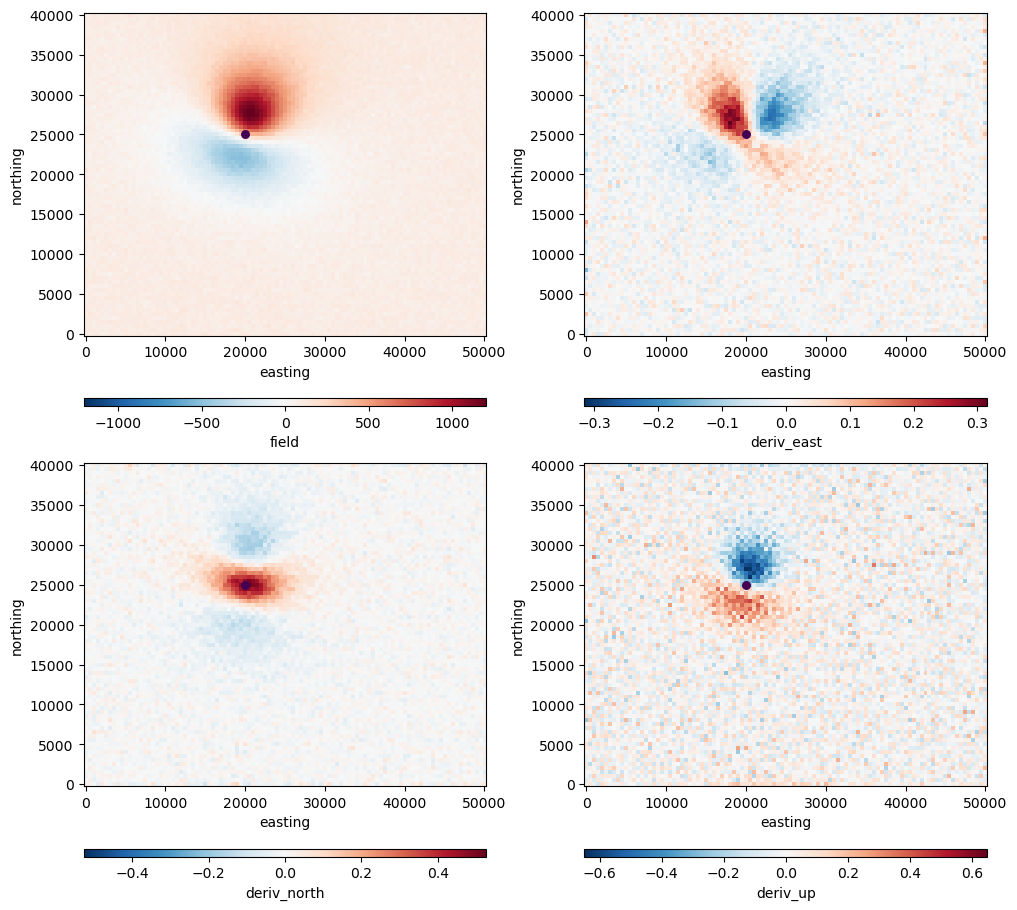

In [2]:
region = [0, 50e3, 0, 40e3]
coordinates = vd.grid_coordinates(region, spacing=500, extra_coords=800)
inclination, declination = -40, 15
base_level = 100
true_coordinates = (20e3, 25e3, -5e3)
magnetic_field = hm.dipole_magnetic(
    coordinates, 
    dipoles=true_coordinates,
    magnetic_moments=hm.magnetic_angles_to_vec(2e12, inclination, declination),
    field="b",
)
main_field = hm.magnetic_angles_to_vec(1, inclination, declination)
magnetic_anomaly = sum(b * f for b, f in zip(magnetic_field, main_field))
magnetic_anomaly += np.random.default_rng(42).normal(0, 15, size=magnetic_anomaly.shape)
magnetic_anomaly += base_level

print(f"Number of data: {magnetic_anomaly.size}")

data = vd.make_xarray_grid(coordinates, magnetic_anomaly, data_names="field", extra_coords_names="height")
data["deriv_east"] = hm.derivative_easting(data.field)
data["deriv_north"] = hm.derivative_northing(data.field)
data["deriv_up"] = hm.derivative_upward(data.field)

fig, axes = plt.subplots(2, 2, figsize=(10, 9), layout='constrained')
for field, ax in zip(["field", "deriv_east", "deriv_north", "deriv_up"], axes.ravel()):
    data[field].plot.pcolormesh(ax=ax, cbar_kwargs=dict(orientation="horizontal", aspect=50))
    ax.set_aspect("equal")
    tmp = ax.scatter(*true_coordinates[:2], c=true_coordinates[2], s=30)
plt.show()

## Euler Deconvolution

In [3]:
ed = euler.EulerDeconvolution(structural_index=3).fit_grid(data.field, data.deriv_east, data.deriv_north, data.deriv_up)
print("Base level:")
print(f"  True      = {base_level}")
print(f"  Estimated = {ed.base_level_}")
print("Position:")
print(f"  True      = {true_coordinates}")
print(f"  Estimated = {ed.source_location_}")

Base level:
  True      = 100
  Estimated = 100.71036534862154
Position:
  True      = (20000.0, 25000.0, -5000.0)
  Estimated = [21749.19116038 23912.48483266 -1867.29349597]


## Euler Inversion

In [4]:
%%time
ei = euler.EulerInversion(structural_index=3).fit_grid(data.field, data.deriv_east, data.deriv_north, data.deriv_up)
print("Base level:")
print(f"  True      = {base_level}")
print(f"  Estimated = {ei.base_level_}")
print("Position:")
print(f"  True      = {true_coordinates}")
print(f"  Estimated = {ei.source_location_}")

Base level:
  True      = 100
  Estimated = 100.58948777338658
Position:
  True      = (20000.0, 25000.0, -5000.0)
  Estimated = [19897.81492197 25118.99628048 -4194.19750512]
CPU times: user 19.3 s, sys: 8 μs, total: 19.3 s
Wall time: 11.5 s


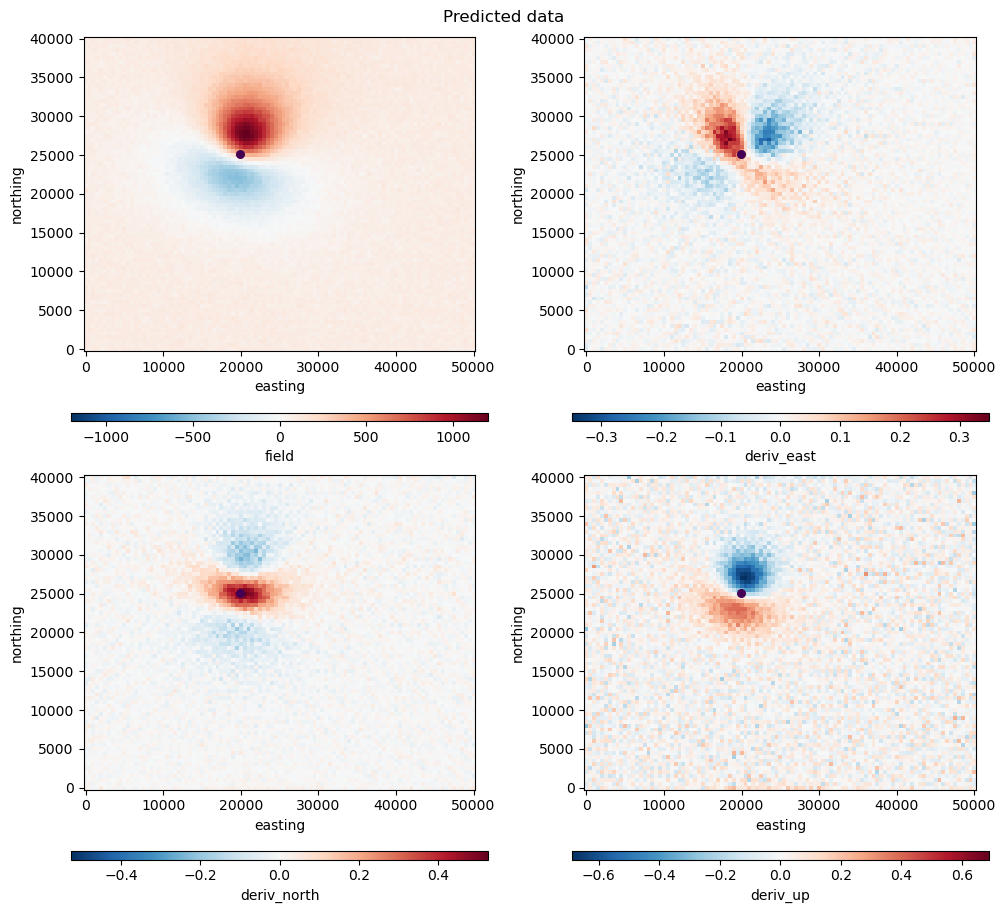

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(10, 9), layout='constrained')
for field, ax in zip(["field", "deriv_east", "deriv_north", "deriv_up"], axes.ravel()):
    ei.predicted_grids_[field].plot.pcolormesh(ax=ax, cbar_kwargs=dict(orientation="horizontal", aspect=50))
    ax.set_aspect("equal")
    tmp = ax.scatter(*ei.source_location_[:2], c=ei.source_location_[2], s=30)
fig.suptitle("Predicted data")
plt.show()

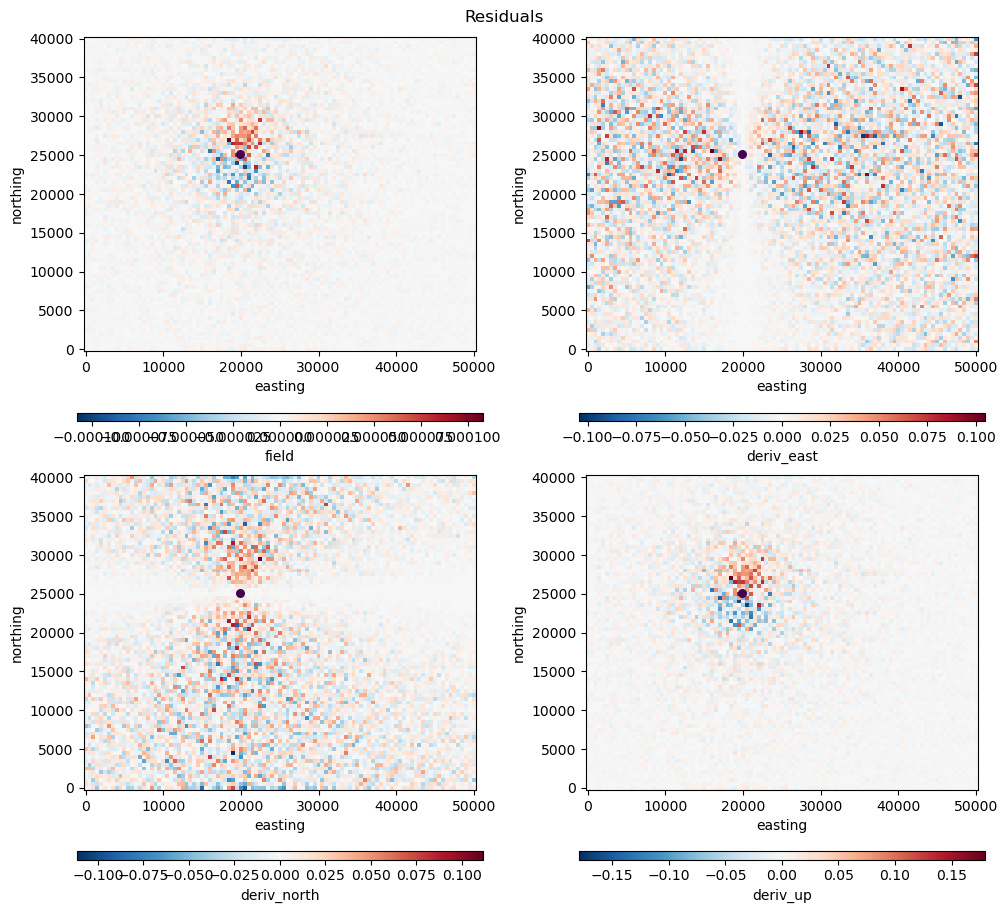

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(10, 9), layout='constrained')
for field, ax in zip(["field", "deriv_east", "deriv_north", "deriv_up"], axes.ravel()):
    (data[field] - ei.predicted_grids_[field]).plot.pcolormesh(ax=ax, cbar_kwargs=dict(orientation="horizontal", aspect=50))
    ax.set_aspect("equal")
    tmp = ax.scatter(*ei.source_location_[:2], c=ei.source_location_[2], s=30)
fig.suptitle("Residuals")
plt.show()

## Show the process per iteration

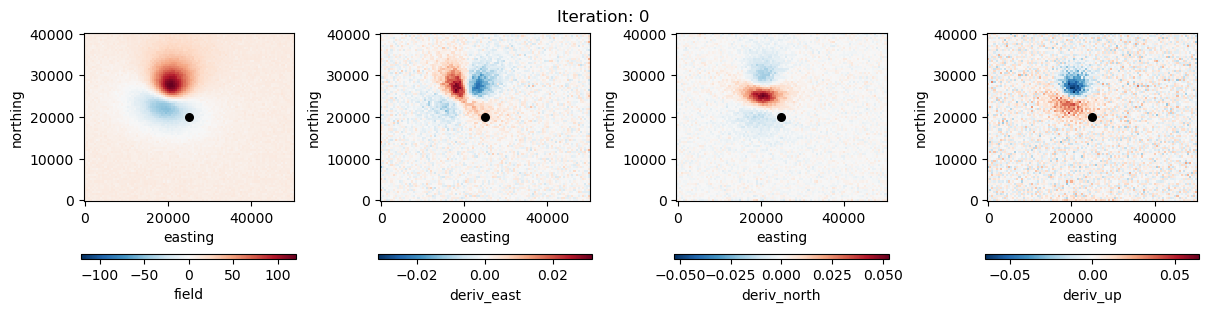

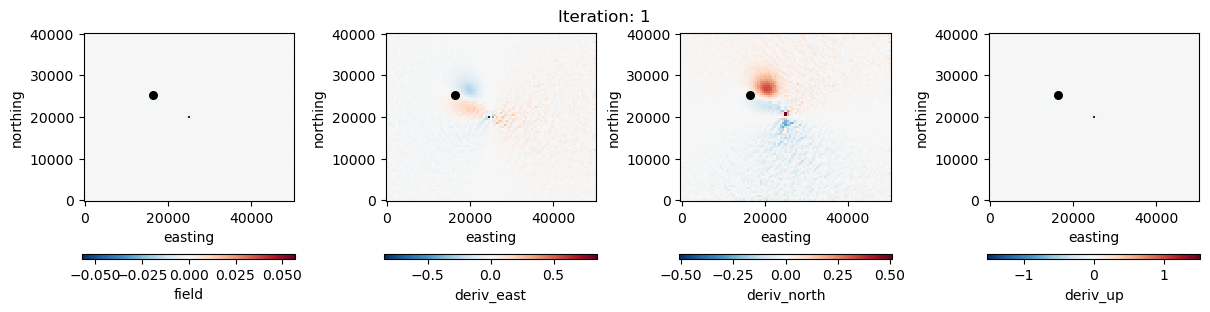

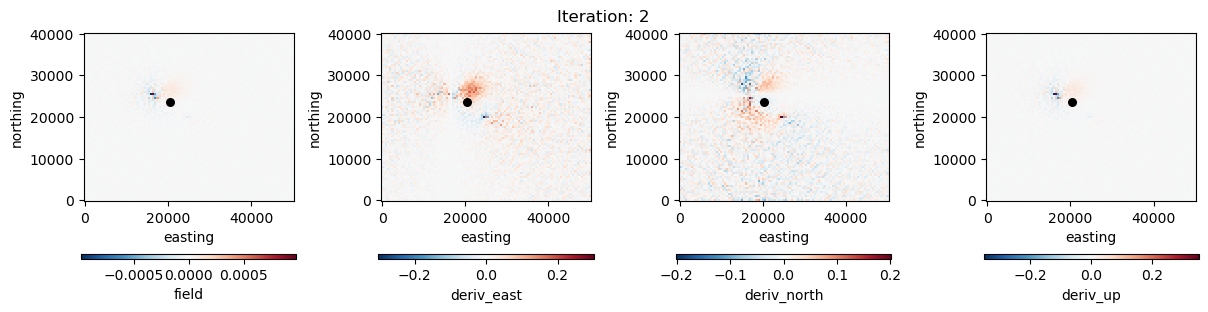

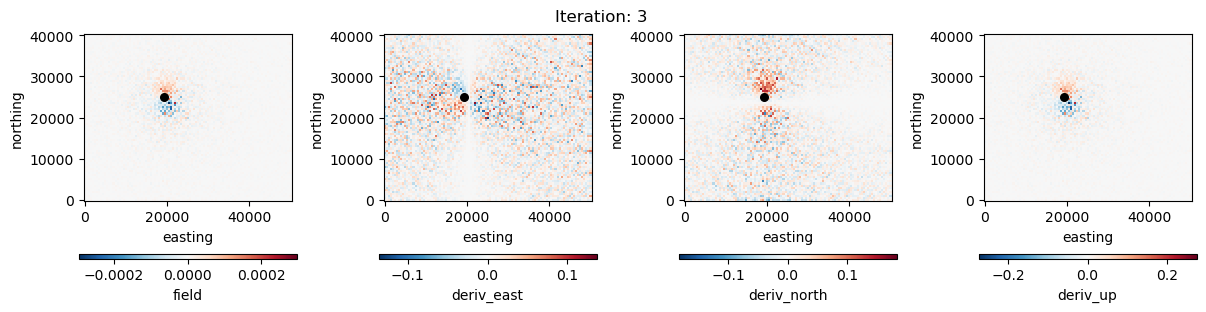

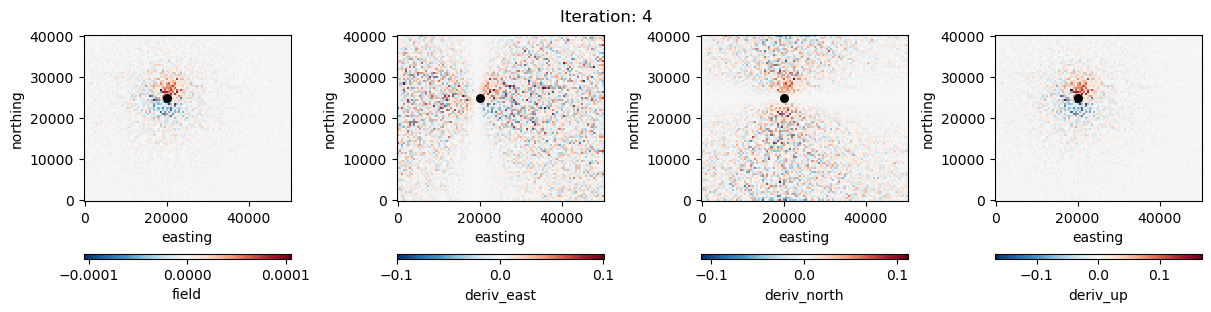

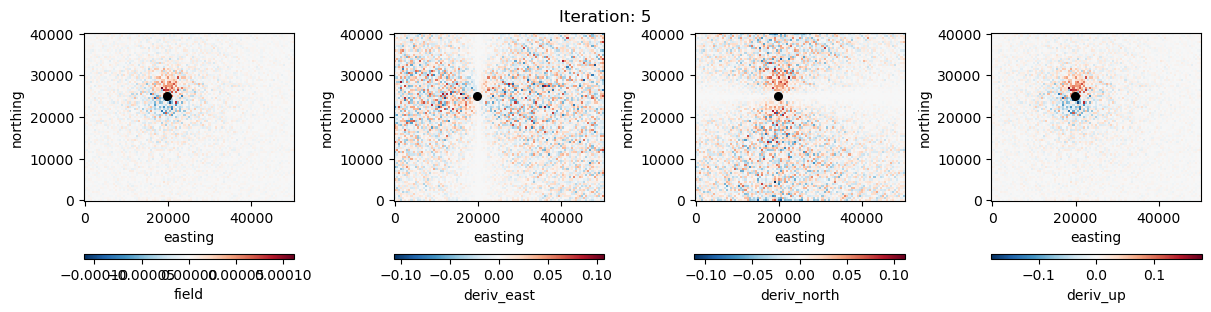

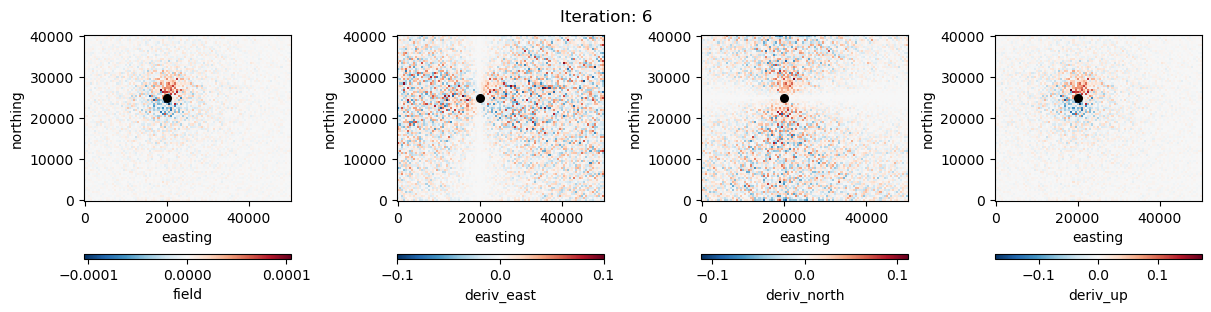

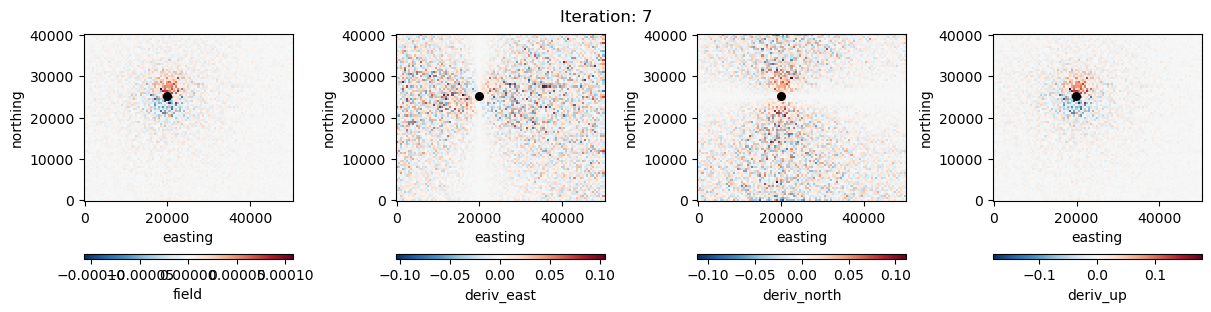

In [7]:
estimates = []
base_levels = []
ei = euler.EulerInversion(structural_index=3, tol=0.1)
for i, _ in enumerate(ei.fit_grid_iterator(data.field, data.deriv_east, data.deriv_north, data.deriv_up)):
    estimates.append(ei.source_location_.copy())
    base_levels.append(ei.base_level_)

    fig, axes = plt.subplots(1, 4, figsize=(12, 3), layout='constrained')
    for field, ax in zip(["field", "deriv_east", "deriv_north", "deriv_up"], axes.ravel()):
        (data[field] - ei.predicted_grids_[field]).plot.pcolormesh(ax=ax, cbar_kwargs=dict(orientation="horizontal", aspect=50))
        ax.set_aspect("equal")
        ax.scatter(*ei.source_location_[:2], c="k", s=30)
    fig.suptitle(f"Iteration: {i}")
    plt.show()
    plt.close()

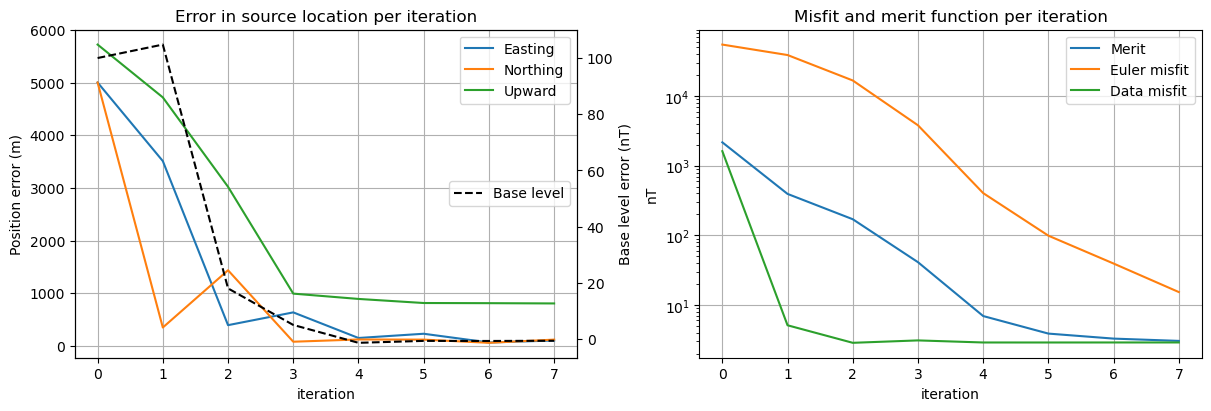

In [8]:
estimates = np.array(estimates)
east_error = np.abs(true_coordinates[0] - estimates[:, 0])
north_error = np.abs(true_coordinates[1] - estimates[:, 1])
up_error = np.abs(true_coordinates[2] - estimates[:, 2])
base_levels = np.array(base_levels)
base_error = base_level - base_levels

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), layout="constrained")

ax1.plot(east_error, label="Easting")
ax1.plot(north_error, label="Northing")
ax1.plot(up_error, label="Upward")
ax1.legend()
twin = ax1.twinx()
twin.plot(base_error, "k--", label="Base level")
twin.set_ylabel("Base level error (nT)")
twin.legend(loc="center right")
ax1.grid()
ax1.set_xlabel("iteration")
ax1.set_ylabel("Position error (m)")
ax1.set_title("Error in source location per iteration")

ax2.plot(ei.merit_, label="Merit")
ax2.plot(ei.euler_misfit_, label="Euler misfit")
ax2.plot(ei.data_misfit_, label="Data misfit")
ax2.legend()
ax2.set_yscale("log")
ax2.grid()
ax2.set_xlabel("iteration")
ax2.set_ylabel("nT")
ax2.set_title("Misfit and merit function per iteration")

plt.show()